# Drug likeness prediction

### Autohrs: Gamba Davide, Margni Nathan, Weithaler Federico (D3A)
### Date: 19.05.2023 Spring Semester

*"Target: The algorithm should be able to predict the drug likeness starting from the SMILES description"*

## Introduction

To predict if a molecule, starting from its SMILES description, it's a drug, or not, we need to have a baseline dataset with positive and negative matches.
In order to do so, we have two datasets "drugs_approved" and "fda_approved" that contains positive data to train our model on. For negatives, we have many options but we chosed "ZINC" and "World drugs". (CHANGE THIS PART?)

In [41]:
# Imports

import pandas as pd
import numpy as np 

# ML libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler


from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# RdKit
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdMolDescriptors, Descriptors, AllChem

import mols2grid

# Imbalanced data
from imblearn.under_sampling import RandomUnderSampler

# Statistics
from scipy import stats

# Mold2 descriptors
from Mold2_pywrapper import Mold2



## Data and preprocessing

 "ZINC15", "ZINC15 with world drugs", "fda approved below 128 atoms", and "drugs approved" are the datasets available already cleaned, in the .smiles format.
 They are used to test the model or to provide negative labels to the train dataset.

 

In [2]:
# read .smiles file
with open('drugability/data/zinc15_nondrugs_sample.smiles', 'r') as f:
    non_drug_sample = f.readlines()
    non_drug_sample = [x.strip() for x in non_drug_sample]

fda_approved = pd.read_csv('drugability/data/fda_approved.csv')


These datasets are instead the ones used mainly for training. "fda_approved.csv" contains the baseline of positive labeled data.

Checking the size of the datasets:

In [3]:
print(fda_approved.shape)

(2136, 5)


In [4]:
fda_approved.head(5)

,DrugBank ID,SMILES,Ro5,bRo5,eRo5
0,DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,False,True,False
1,DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,False,True,False
2,DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,False,True,False
3,DB00027,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,False,True,False
4,DB00035,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,False,True,False


In [5]:
print(len(non_drug_sample))

4987


In [6]:
non_drug_sample[:5]

['Cc1c(C(=O)Nc2ccccc2C(N)=O)nnn1-c1ccc2ncccc2c1',
 'C[C@H]1CCCC[C@H]1NC(=O)NC(=O)CN1CCc2ccc([N+](=O)[O-])cc2C1',
 'Brc1ccccc1-c1nc2c3ccccc3ncn2n1',
 'CC[C@H](C)NC(=O)Nc1ccnn1C1CCCC1',
 'CCn1c(SCc2cc(C(=O)OC)c(C)o2)nnc1-c1ccccc1OC']

### Checking for unique mol

In [7]:
def validate_unique(df):
    mol_list = []
    valid_rows = []
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['SMILES'])
        if mol is not None:
            mol_list.append(mol)
            valid_rows.append(row)

    valid_df = pd.DataFrame(valid_rows)

    # reset index to avoid tensor slicing errors
    valid_df = valid_df.reset_index(drop=True)
    return valid_df

In [8]:
valid_fda_approved = validate_unique(fda_approved)
valid_non_drug_sample = validate_unique(pd.DataFrame(non_drug_sample, columns=['SMILES']))

valid_fda_approved["ROMol"] = valid_fda_approved["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
valid_fda_approved['CanonicalSMILES']= valid_fda_approved['ROMol'].apply(lambda x: Chem.MolToSmiles(x))

valid_non_drug_sample["ROMol"] = valid_non_drug_sample["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
valid_non_drug_sample['CanonicalSMILES']= valid_non_drug_sample['ROMol'].apply(lambda x: Chem.MolToSmiles(x))

df_fda_approved = valid_fda_approved
df_non_drug_sample = valid_non_drug_sample

print("Duplicates found for fda_approved: ", df_fda_approved.shape[0]-fda_approved.shape[0])
print("Duplicates found for non_drug_sample: ", df_non_drug_sample.shape[0]-len(non_drug_sample))


Duplicates found for fda_approved:  0
Duplicates found for non_drug_sample:  0


All the molecules are unique.
Let's create two new, clean, dataframes with only the information we need, and merge them to build our dataset that we'll later split into the train and test. We will evaluate all our models with cross-validation.

In [9]:
# create a dataset with the smiles from fda_approved dataset and non_drug_sample list, assigning label 1 to fda_approved and 0 to non_drug_sample
df_drugs = pd.DataFrame({'smiles': fda_approved.SMILES, 'label': 1})
df_non_drugs = pd.DataFrame({'smiles': non_drug_sample, 'label': 0})

# concatenate the two dataframes
df = pd.concat([df_drugs, df_non_drugs], ignore_index=True)

Let's visualize the dataframe:

In [10]:
df.head(5)

,smiles,label
0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,1
1,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,1
2,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,1
3,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,1
4,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,1


Let's check the proportions of the data, between the label zero and one.

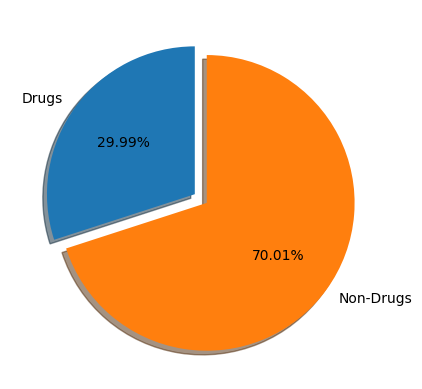

In [11]:
# plot piechart with label propportions

labels = 'Drugs', 'Non-Drugs'
sizes = [len(df_drugs), len(df_non_drugs)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Non-Drugs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
plt.show()  

Since the data is (relatively) slightly unbalanced, we perform data balancing, utilizing the random undersampler of ImbalancedLearn.

In [12]:
# balance the label with random undersampling 
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(df[['smiles']], df['label'])

# recreate the dataframe with the balanced data
balanced_df = pd.concat([pd.DataFrame(X_res, columns=['smiles']), pd.DataFrame(y_res, columns=['label'])], axis=1)

Let's check again how the data is distributed:

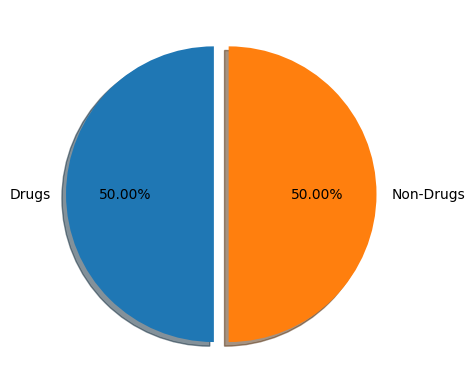

In [13]:
labels = 'Drugs', 'Non-Drugs'
sizes = [len(balanced_df[balanced_df["label"] == 1]), len(balanced_df[balanced_df["label"] == 0])]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Non-Drugs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
plt.show()  

In [14]:
balanced_df.head(5)

,smiles,label
0,COc1ccccc1/C=N/c1ccccc1C#N,0
1,Cc1nccn1-c1ccc([C@@H](C)NC(=O)[C@H](C)OCC2CC2)cc1,0
2,C#CCNC(=O)CNC(=O)Nc1cccc(C[S@](=O)c2ccccc2)c1,0
3,Cc1cc(OC(F)F)ccc1NC(=O)N(CCO)Cc1ccco1,0
4,CCc1ccc([C@H](C)NC(=O)[C@]2(C)CC2(Br)Br)cc1,0


Now we generate a column with the mol object in order to visualize the moelcules and generate later on the features such as descriptors and fingerprints.

In [15]:
# generate column with mol objects

df = balanced_df.copy()

df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

### Visualize the moelcules

In [16]:
# Visualize the molecules
mols2grid.display(df['mol'])

MolGridWidget()

### Generate fingerprints and descriptors

In [17]:
#compute morgan fingerprints for the smiles in the df 

def smiles_to_morgan_fingerprint(mol, radius=2, nBits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return fp

df['morgan_fingerprint'] = df['mol'].apply(smiles_to_morgan_fingerprint)



# add column for MACCS keys
def smiles_to_maccs_keys(mol):
    maccs_keys = MACCSkeys.GenMACCSKeys(mol)
    return maccs_keys

df['maccs_keys'] = df['mol'].apply(smiles_to_maccs_keys)


"""
# add column for ECFP4 keys
def smiles_to_ecfp4_keys(mol):
    ecfp4_keys = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return ecfp4_keys

df['ecfp4_keys'] = df['mol'].apply(smiles_to_ecfp4_keys)
"""

# add rdkit descriptors
keys = [x[0] for x in Descriptors.descList]
desc = dict(Descriptors.descList)
keys.sort()

def vectorize_rdkit(mol):
   return [desc[x](mol) for x in keys]

df['rdkit_descriptors'] = df['mol'].apply(vectorize_rdkit)

# add mold2 descriptors
mols = df['mol'].tolist()
mold2 = Mold2()
mold2_features = mold2.calculate(mols)

mold2_features = mold2_features.to_numpy()
df['mold2'] = mold2_features.tolist()

Mold2 calculates a large and diverse set of molecular descriptors encoding two-
dimensional chemical structure information. Comparative analysis of Mold2 descriptors
with those calculated from commercial software on several published datasets
demonstrated that Mold2 descriptors convey sufficient structural information. In addition,
better models were generated using Mold2 descriptors than the compared commercial
software packages. This publicly available software is developed by the Center for
Bioinformatics, which is led by Dr. Weida Tong, at the National Center for Toxicological
Research (NCTR).
    
Mold2 is a product designed and produced by the National Center for Toxicological
Research (NCTR).  FDA and NCTR retain ownership of this product.

Please address any questions or suggestions to Dr. Huixiao Hong, National Center for Toxicological
Research, at 870-543-7296 or Huixiao.Hong@fda.hhs.gov.

###################################

Should you publish results based on the Mold² desc

This function extracts some meaningful descriptors

In [18]:
def extract_features(mol, return_array=True):

    molecular_weight = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    num_hydrogen_bond_donors = Descriptors.NumHDonors(mol)
    num_hydrogen_bond_acceptors = Descriptors.NumHAcceptors(mol)


    if return_array:
        features = np.array([molecular_weight, logp, num_rotatable_bonds, num_hydrogen_bond_donors, num_hydrogen_bond_acceptors])
        return features
    else:
        features = {
            'molecular_weight': molecular_weight,
            'logP': logp,
            'num_rotatable_bonds': num_rotatable_bonds,
            'num_hydrogen_bond_donors': num_hydrogen_bond_donors,
            'num_hydrogen_bond_acceptors': num_hydrogen_bond_acceptors
        }

        return features

Here we generate a separe dataframe, with all the features divided. This dataframe will come in handy when performing feature importance.

In [19]:
# create df with all the single values from the fingerprints
def create_sep_cols(df, col_name):
    array_size = len(df[col_name][0])
    for i in range(array_size):
        df = pd.concat([df, df[col_name].apply(lambda x: x[i]).rename(col_name + '_' + str(i))], axis=1)
    return df

sep_df = df.copy()

cols = ['morgan_fingerprint',  'maccs_keys',  'mold2']

for col in cols:
    sep_df = create_sep_cols(sep_df, col)


# also for rdkit descriptors with correct name
for i in range(len(keys)):
    sep_df = pd.concat([sep_df, sep_df['rdkit_descriptors'].apply(lambda x: x[i]).rename('rdkit_' + keys[i])], axis=1)


We apply the functions to generate the features to the dataframe and we append the results to the dataset.

In [20]:
df['features'] = df['mol'].apply(extract_features)

list_dicts_features  = df['mol'].apply(extract_features, return_array=False).tolist()

# add columns for each feature with also the name of the feature
add_df = pd.DataFrame(list_dicts_features)
# add 'feature_' string to all the columns in add_df
add_df.columns = ['feature_' + str(col) for col in add_df.columns]
sep_df = pd.concat([sep_df, add_df], axis=1)

Clean up some old columns that we used to generate all the different features.

In [21]:
# remove the cols with the original data
sep_df = sep_df.drop(columns=['smiles', 'mol', 'morgan_fingerprint', 'maccs_keys', 'mold2', 'rdkit_descriptors'])

In [22]:
cols = ['morgan_fingerprint', 'maccs_keys', 'mold2', 'rdkit_descriptors']

for col in cols:
    print("lenght array for " + col + ": " + str(len(df[col][0])))


lenght array for morgan_fingerprint: 2048
lenght array for maccs_keys: 167
lenght array for mold2: 777
lenght array for rdkit_descriptors: 208


In [23]:

# print shape of df
print("shapes before dropping nan rows")
print(df.shape)
print(sep_df.shape)
# check index rows with nan in sep_df
nan_rows = sep_df[sep_df.isnull().any(axis=1)]

# remove them from sep_df and df 
sep_df = sep_df.drop(nan_rows.index)
df = df.drop(nan_rows.index)

# print shape of df
print("shapes after dropping nan rows")
print(df.shape)
print(sep_df.shape)

shapes before dropping nan rows
(4272, 8)
(4272, 3206)
shapes after dropping nan rows
(4251, 8)
(4251, 3206)


In [24]:
# convert all columns to float
sep_df = sep_df.astype(float)

We also cap the outliers with a simple quantile method.

In [25]:
# cap outliers with IQR
def cap_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    df[col_name] = df[col_name].apply(lambda x: fence_low if x < fence_low else fence_high if x > fence_high else x)
    return df

for col in sep_df.columns:
    sep_df = cap_outliers(sep_df, col)

We save the dataframes to not compute everytime all the features, which are computationally expensive.

In [26]:
# save sep df
sep_df.to_csv('drugability/data/sep_df.csv', index=False)
df.to_csv('drugability/data/df.csv', index=False)

### Random forest classifier (for feature importance)

We use the sep_df to perform feature importance with a random forest classifier.

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(sep_df.drop('label',axis=1),
                                                    sep_df['label'], test_size=0.30,
                                                    random_state=101)

In [28]:
# train random forest 
rfc = RandomForestClassifier(n_estimators=500, max_depth=50)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, n_estimators=500)

In [29]:

# accuracy 
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))
print("Accuracy on test set:", accuracy_score(y_test, rfc_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       638
         1.0       0.87      0.85      0.86       638

    accuracy                           0.86      1276
   macro avg       0.86      0.86      0.86      1276
weighted avg       0.86      0.86      0.86      1276

Accuracy on test set: 0.8644200626959248


<Axes: >

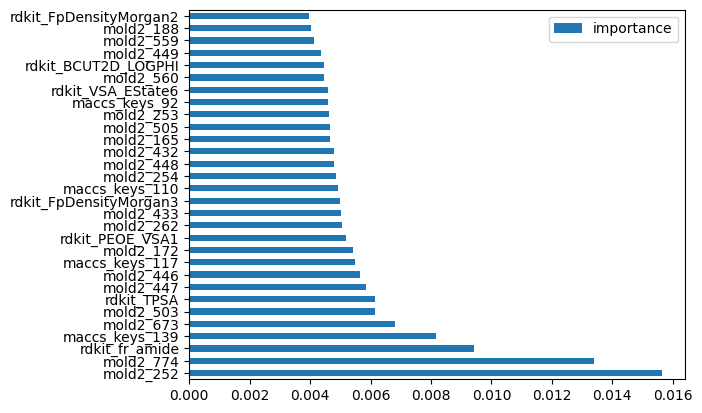

In [30]:
# plot feature importance from rf
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                      index = X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(30).plot(kind='barh')


Here, with the help of these two plots, we can visualize the importance of the single features.

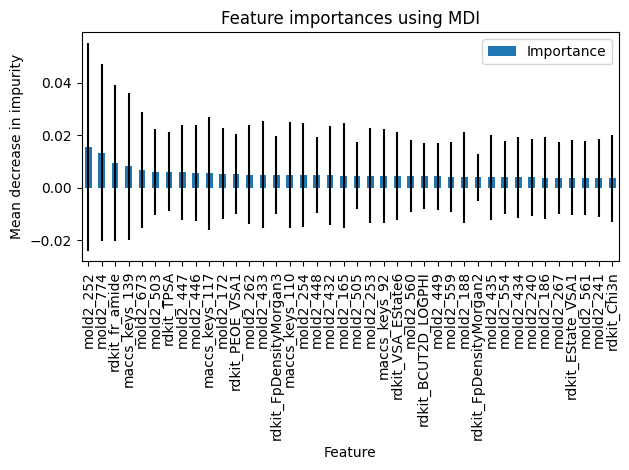

In [31]:
feature_names = X_train.columns
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

# Convert importances to a DataFrame for easier handling
forest_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Std': std
})

# Sort by importance
forest_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Select top n
n_top = 40  # change this to your desired n
forest_importances_top_n = forest_importances.head(n_top)

# Plot
fig, ax = plt.subplots()
forest_importances_top_n.plot.bar(x='Feature', y='Importance', yerr='Std', ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


we generate a dataset with only the top 50 features in importance.

In [32]:
# create a dataset with only top 50 features
top_features = feature_importances.head(100).index.tolist()
top_features.append('label')
top_df = sep_df[top_features]


In [33]:
from sklearn.model_selection import cross_val_score


# train a random forest for each fingerprint and compare the scores 
def train_rf(df, fingerprint, n_estimators=200):
    X, y = np.array(list(df[fingerprint])), df['label']
    

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.30,
                                                    random_state=101)

    # cross validation rf
    rf = RandomForestClassifier()
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    # print mean score for fingerprint
    print(f"rf CV score with {fingerprint}: {scores.mean().round(3)}")


fingerprints = ['morgan_fingerprint', 'maccs_keys',  'mold2', 'features']

for fingerprint in fingerprints:
    df['fingerprint'] = df[fingerprint]
    train_rf(df, fingerprint)



rf CV score with morgan_fingerprint: 0.86
rf CV score with maccs_keys: 0.844
rf CV score with mold2: 0.846
rf CV score with features: 0.751


After comparing the features that lead to a better score, we can say that morgan fingerprints seem like the best option.

### Clustering on morgan fingerprints

In [34]:
# Clustering on morgan fingerprints
from sklearn.cluster import KMeans

# create a dataset with only morgan fingerprints

morgan_fingerprints = np.array(df['morgan_fingerprint'].tolist()) 
labels = df['label'].tolist()


# train kmeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(morgan_fingerprints)

# get the labels from the kmeans
kmeans_labels = kmeans.labels_

c:\Installed_programs\Conda\envs\bio_grasso\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
# import silhouette score
from sklearn.metrics import silhouette_score
from tqdm import tqdm

cluster_range = range(3,40)
score_list = []
sum_of_squared_distances = []

for k in tqdm(cluster_range):
    km = KMeans(n_clusters=k,random_state=42)
    cluster_labels = km.fit_predict(morgan_fingerprints)
    score = silhouette_score(morgan_fingerprints,cluster_labels)
    sum_of_squared_distances.append(km.inertia_)
    score_list.append([k,score])

#Put the silhouette scores into a dataframe
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])
score_df.head()

  0%|          | 0/37 [00:00<?, ?it/s]c:\Installed_programs\Conda\envs\bio_grasso\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/37 [00:02<01:37,  2.70s/it]c:\Installed_programs\Conda\envs\bio_grasso\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  5%|▌         | 2/37 [00:05<01:46,  3.03s/it]c:\Installed_programs\Conda\envs\bio_grasso\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  8%|▊         | 3/37 [00:09<01:54,  3.37s/it]c:\Installed_programs\Conda\envs\bio_grasso\lib\site-packag

,K,Silhouette Score
0,3,0.009518
1,4,0.003538
2,5,-0.017946
3,6,-0.017318
4,7,-0.013370


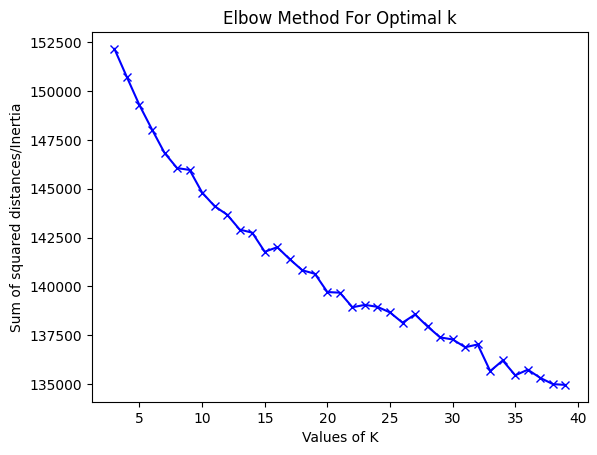

In [36]:
plt.plot(cluster_range,sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()


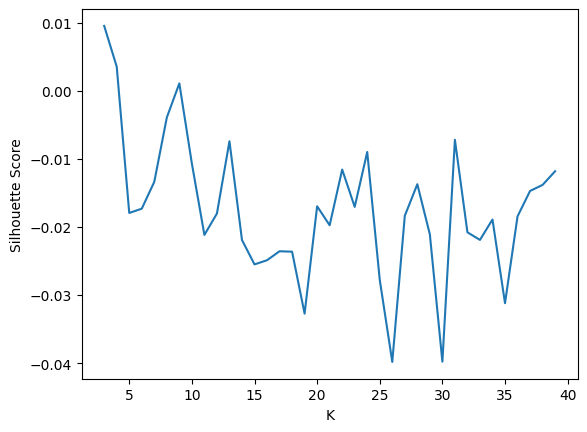

In [37]:
#Plot the silhouette scores as a function of the number of clusters

ax = sns.lineplot(x="K",y="Silhouette Score",data=score_df)


In [38]:
num_clusters = 24
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(morgan_fingerprints)
cluster_list = km.predict(morgan_fingerprints)

c:\Installed_programs\Conda\envs\bio_grasso\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


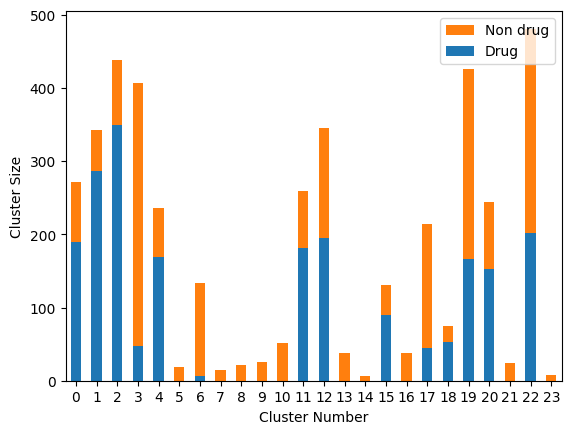

In [39]:
# create dummy data
np.random.seed(42)
df_plot = pd.DataFrame({'Label': df.label, "cluster_list": cluster_list})

# group by Label and cluster_list to get counts of each Label in each cluster
grouped = df_plot.groupby(['cluster_list', 'Label']).size().unstack(fill_value=0)

# plot the stacked barplot
ax = grouped.plot(kind='bar', stacked=True)

# set the axis labels and tick labels
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Cluster Size")
ax.tick_params(axis='x', rotation=0)

# create a legend for the bar colors
handles, labels = ax.get_legend_handles_labels()
colors = ['tab:blue', 'tab:orange']
labels = ['Drug', 'Non drug']
ax.legend(reversed(handles), reversed(labels), loc='upper right')
plt.show()

### Functions

Some function to help us evaluate the models with the same metrics every time. We also perform cross validation for each model, with 5 folds.

In [40]:

# function to evaluate the model
def evaluate_model(model, X_test, y_test, threshold=0.5):
    predictions = model.predict(X_test)
    predictions = (predictions > threshold)
    print(classification_report(y_test,predictions))
    print("Accuracy on test set: ", accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test,predictions)
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')


# cross validation function 
def cross_validation(X, y, model_func, n_splits=5, verbose=0, epochs=5):

  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=n_splits, shuffle=True)
  
  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X, y):

    # Define the model architecture
    model = model_func()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    X_train = X[train]
    y_train = y[train]

    X_test = X[test]
    y_test = y[test]

    # Fit data to model
    history = model.fit(X_train, y_train,
                batch_size=128,
                epochs=epochs,
                verbose=verbose)

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=verbose)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

  print("\nMean accuracy in folds: ", np.mean(acc_per_fold))
  
  return acc_per_fold, loss_per_fold


def cap_outliers_descr(X_train, X_test):
    num_features = X_train.shape[1]
    X_train_no_outliers = np.empty_like(X_train)
    X_test_no_outliers = np.empty_like(X_test)

    upper_bounds = []
    for i in range(num_features):
    
        feature = X_train[:, i]
        Q1 = np.percentile(feature, 25)
        Q3 = np.percentile(feature, 75)
        IQR = Q3 - Q1
        mean = np.mean(feature)

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        upper_bounds.append(upper_bound)

        X_train_no_outliers[:, i] = np.where((feature <= upper_bound), feature, upper_bound)
        X_test_no_outliers[:, i] = np.where((X_test[:, i] <= upper_bound), X_test[:, i], upper_bound)

    

    return X_train_no_outliers, X_test_no_outliers

### Feed forward network with all the features

In [42]:
models_df = pd.DataFrame(columns=['Model', 'features', 'cv_accuracy', 'test_accuracy', 'model_instance'])

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.37427589297294617; accuracy of 89.11764621734619%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.6315094232559204; accuracy of 86.32352948188782%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5149804949760437; accuracy of 86.17647290229797%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.283733993768692; accuracy of 92.20588207244873%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.3681453764438629; accuracy of 89.99999761581421%

Mean accuracy in folds:  88.76470565795898

Evaluation on test set: 
27/27 [==============================] - 0s 2ms/step
       

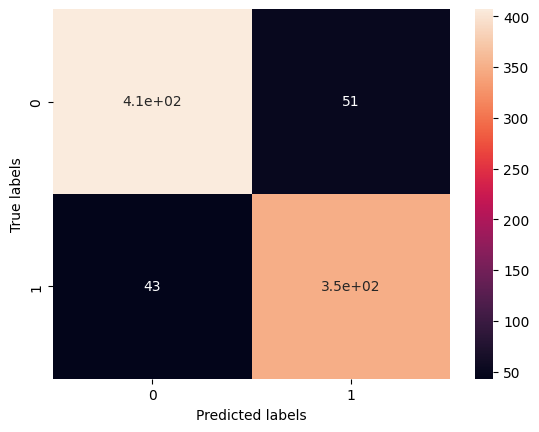

In [43]:
# import pca
from sklearn.decomposition import PCA

X = np.array(list(sep_df.drop("label", axis=1).values))
y = np.array(list(sep_df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# pca the data
pca_model_1 = PCA(n_components=500)
X_train = pca_model_1.fit_transform(X_train)
X_test = pca_model_1.transform(X_test)


def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(1500, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(750, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(350, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe 
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)

add_df = pd.DataFrame({'Model': 'MLP', 'features': 'all features and pca', 'cv_accuracy': np.mean(acc_per_fold), 
                              'test_accuracy': test_acc, 
                              'model_instance': model}, index=[0])

models_df = pd.concat([models_df, add_df], ignore_index=True)

### Feed foward network with only features

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.5882779955863953; accuracy of 70.14706134796143%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.6067621111869812; accuracy of 67.5000011920929%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5617712140083313; accuracy of 71.6176450252533%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.5402920842170715; accuracy of 75.58823823928833%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.5698738098144531; accuracy of 68.23529601097107%

Mean accuracy in folds:  70.6176483631134

Evaluation on test set: 
27/27 [==============================] - 0s 1ms/step
          

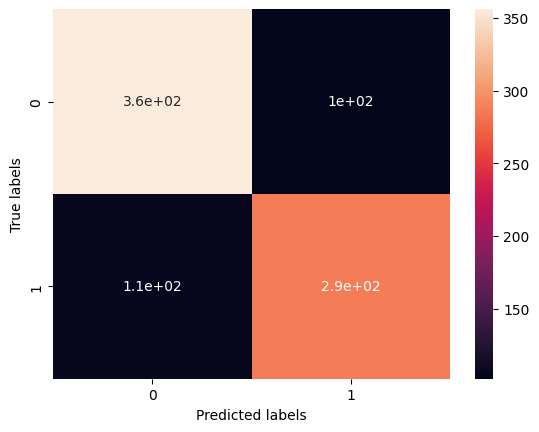

In [44]:


X = np.array(list(df["features"]))
y = np.array(list(df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(60, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(30, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(15, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)

# add a row to the models_df dataframe 
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)

add_df = pd.DataFrame({'Model': 'MLP', 'features': 'features', 'cv_accuracy': np.mean(acc_per_fold),
                              'test_accuracy': test_acc,
                              'model_instance': model}, index=[0])

models_df = pd.concat([models_df, add_df], ignore_index=True)

### Feed foward network with morgan fingerprints 

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.6297904849052429; accuracy of 85.73529124259949%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.533013105392456; accuracy of 86.76470518112183%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5840591192245483; accuracy of 87.64705657958984%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.6652905344963074; accuracy of 84.85293984413147%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.5198678374290466; accuracy of 87.5%

Mean accuracy in folds:  86.49999856948853

Evaluation on test set: 
27/27 [==============================] - 0s 4ms/step
              precisi

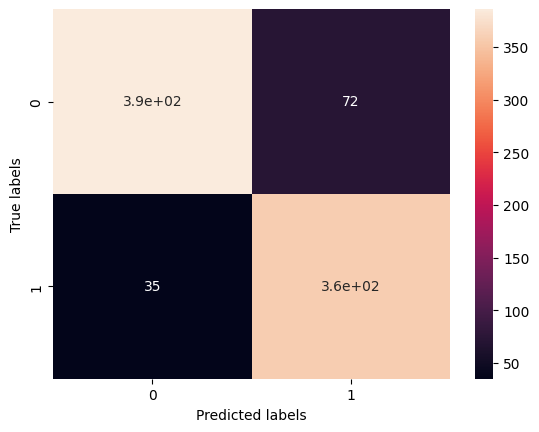

In [45]:


X = np.array(list(df["morgan_fingerprint"]))
y = np.array(list(df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(2000, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1000, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)

# add a row to the models_df dataframe
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)

add_df = pd.DataFrame({'Model': 'MLP', 'features': 'morgan fingerprint', 'cv_accuracy': np.mean(acc_per_fold),
                              'test_accuracy': test_acc,
                              'model_instance': model}, index=[0])

models_df = pd.concat([models_df, add_df], ignore_index=True)


### Suport vector machine with morgan fingerprints

Accuracy: 0.87 (+/- 0.02)
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       458
           1       0.87      0.90      0.88       393

    accuracy                           0.89       851
   macro avg       0.89      0.89      0.89       851
weighted avg       0.89      0.89      0.89       851

Accuracy on test set:  0.8918918918918919


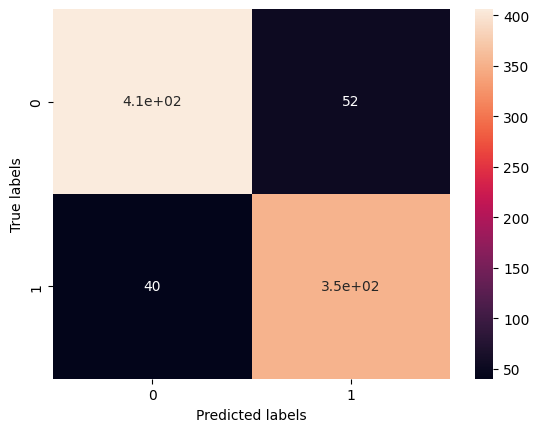

In [46]:
# import svc
from sklearn.svm import SVC

# import cross validation 
from sklearn.model_selection import cross_val_score

# train random forest with crossvalidation 
X = np.array(list(df["morgan_fingerprint"]))
y = np.array(list(df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# cross_val_score with random forest 
svc = SVC()
scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# train random forest
svc = SVC()
svc.fit(X_train, y_train)

# evaluate model
evaluate_model(svc, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe
preds =  svc.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)


# add a row to the models_df dataframe
add_df = pd.DataFrame({'Model': 'Support vector machine', 'features': 'moorgan_fingerprint', 'cv_accuracy': np.mean(scores)*100,
                                'test_accuracy': test_acc,      
                                'model_instance': svc}, index=[0])

models_df = pd.concat([models_df, add_df], ignore_index=True)


### Feed foward network with mold2 descriptors

C:\Users\natha\AppData\Local\Temp\ipykernel_9552\1007302835.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X.astype(np.float)


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.34725597500801086; accuracy of 87.05882430076599%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.2790454924106598; accuracy of 87.5%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.3604763150215149; accuracy of 83.08823704719543%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.3629961311817169; accuracy of 85.88235378265381%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.4102818965911865; accuracy of 84.70588326454163%

Mean accuracy in folds:  85.64705967903137

Evaluation on test set: 
27/27 [==============================] - 0s 3ms/step
              preci

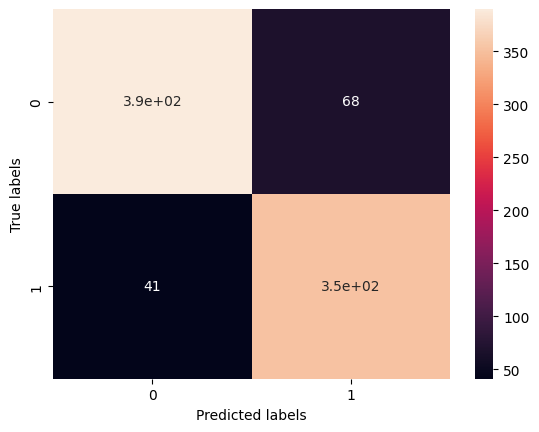

In [47]:


X = np.array(list(df["mold2"]))
X = X.astype(np.float)
y = np.array(list(df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test = cap_outliers_descr(X_train, X_test)

# normalize data with robust scaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(1500, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(700, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(300, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)

# add a row to the models_df dataframe
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)


add_df = pd.DataFrame({'Model': 'MLP', 'features': 'mold2', 'cv_accuracy': np.mean(acc_per_fold),
                              'test_accuracy': test_acc,  
                              'model_instance': model}, index=[0])

models_df = pd.concat([models_df, add_df], ignore_index=True)


### Random forest with mold2

C:\Users\natha\AppData\Local\Temp\ipykernel_9552\3257296590.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X.astype(np.float)


Accuracy: 0.85 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       458
           1       0.84      0.88      0.86       393

    accuracy                           0.87       851
   macro avg       0.87      0.87      0.87       851
weighted avg       0.87      0.87      0.87       851

Accuracy on test set:  0.8672150411280846


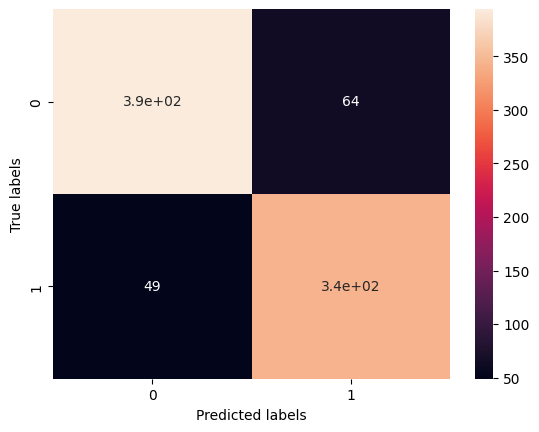

In [48]:
# import cross validation 
from sklearn.model_selection import cross_val_score

# train random forest with crossvalidation 
X = np.array(list(df["mold2"]))
X = X.astype(np.float)
y = np.array(list(df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# cross_val_score with random forest 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# train random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# evaluate model
evaluate_model(rf, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe
preds =  rf.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)


# add a row to the models_df dataframe
add_df = pd.DataFrame({'Model': 'Random Forest', 'features': 'mold2', 'cv_accuracy': np.mean(scores)*100,
                                'test_accuracy': test_acc,      
                                'model_instance': '/'}, index=[0])

models_df = pd.concat([models_df, add_df], ignore_index=True)

### Feed foward network with maccs keys

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.38015469908714294; accuracy of 83.97058844566345%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.35894495248794556; accuracy of 84.5588207244873%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.39708176255226135; accuracy of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.44512858986854553; accuracy of 80.29412031173706%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.4176935851573944; accuracy of 79.85293865203857%

Mean accuracy in folds:  81.73529386520386

Evaluation on test set: 
27/27 [==============================] - 0s 2ms/step
     

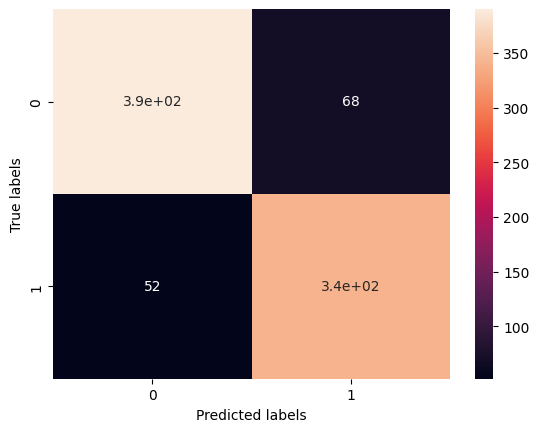

In [49]:
X = np.array(list(df["maccs_keys"]))
y = np.array(list(df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)

add_df = pd.DataFrame({'Model': 'MLP', 'features': 'maccs keys', 'cv_accuracy': np.mean(acc_per_fold),
                              'test_accuracy': test_acc,    
                              'model_instance': model}, index=[2])

models_df = pd.concat([models_df, add_df], ignore_index=True)



### Feed foward network with rdkit descriptors

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.33306780457496643; accuracy of 85.58823466300964%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.3111976981163025; accuracy of 86.61764860153198%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.3352705240249634; accuracy of 84.5588207244873%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.3228377103805542; accuracy of 86.02941036224365%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.36862877011299133; accuracy of 83.52941274642944%

Mean accuracy in folds:  85.2647054195404

Evaluation on test set: 
27/27 [==============================] - 0s 1ms/step
       

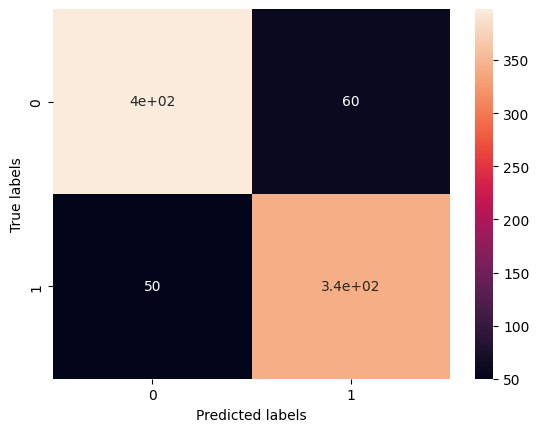

In [50]:
X = np.array(list(df["rdkit_descriptors"]))
y = np.array(list(df["label"]))


# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize data

X_train, X_test = cap_outliers_descr(X_train, X_test)

# normalize data with robust scaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.1))

  
  model.add(Dense(25, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)

add_df = pd.DataFrame({'Model': 'MLP', 'features': 'rdkit', 'cv_accuracy': np.mean(acc_per_fold),
                                'test_accuracy': test_acc,      
                                'model_instance': model}, index=[3])

models_df = pd.concat([models_df, add_df], ignore_index=True)

### Random forest with rdkit


Accuracy: 0.86 (+/- 0.02)
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       458
           1       0.86      0.86      0.86       393

    accuracy                           0.87       851
   macro avg       0.87      0.87      0.87       851
weighted avg       0.87      0.87      0.87       851

Accuracy on test set:  0.8742655699177438


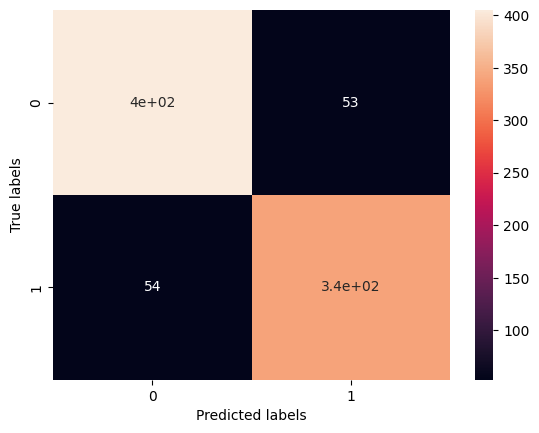

In [51]:

# import cross validation 
from sklearn.model_selection import cross_val_score

# train random forest with crossvalidation 
X = np.array(list(df["rdkit_descriptors"]))
y = np.array(list(df["label"]))


# split train and test with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = cap_outliers_descr(X_train, X_test)

# cross_val_score with random forest 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# train random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# evaluate model
evaluate_model(rf, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe
preds =  rf.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)


# add a row to the models_df dataframe
add_df = pd.DataFrame({'Model': 'Random Forest', 'features': 'rdkit', 'cv_accuracy': np.mean(scores)*100,
                                'test_accuracy': test_acc,      
                                'model_instance': '/'}, index=[0])

models_df = pd.concat([models_df, add_df], ignore_index=True)

<Axes: >

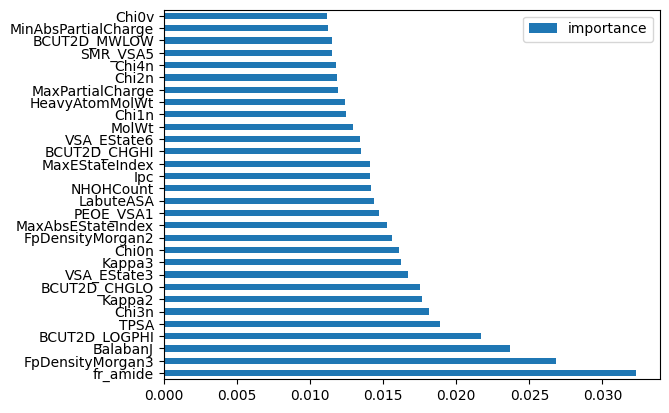

In [52]:
# plot feature importance from rf
feature_importances = pd.DataFrame(rf.feature_importances_,
                                      index = keys,
                                        columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(30).plot(kind='barh')

### AE model on with all features

In [63]:
# import robust scaler 
from sklearn.preprocessing import RobustScaler

X = np.array(list(sep_df.drop(["label"], axis=1).values))
y = np.array(list(sep_df["label"]))

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = cap_outliers_descr(X_train, X_test)

# scale the data 
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
# Define the size of the encoded representations
encoding_dim = 2000

# layers
input_data = Input(shape=(X_train.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_data)
decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)


# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [65]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# we can extract features (encoding) with the encoder model
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

Epoch 1/10
107/107 [==============================] - 4s 35ms/step - loss: 0.0968 - val_loss: 0.0768
Epoch 2/10
107/107 [==============================] - 4s 33ms/step - loss: 0.0785 - val_loss: 0.0723
Epoch 3/10
107/107 [==============================] - 4s 34ms/step - loss: 0.0751 - val_loss: 0.0701
Epoch 4/10
107/107 [==============================] - 3s 32ms/step - loss: 0.0734 - val_loss: 0.0686
Epoch 5/10
107/107 [==============================] - 4s 33ms/step - loss: 0.0721 - val_loss: 0.0677
Epoch 6/10
107/107 [==============================] - 4s 34ms/step - loss: 0.0714 - val_loss: 0.0673
Epoch 7/10
107/107 [==============================] - 3s 33ms/step - loss: 0.0709 - val_loss: 0.0668
Epoch 8/10
107/107 [==============================] - 4s 35ms/step - loss: 0.0704 - val_loss: 0.0664
Epoch 9/10
107/107 [==============================] - 4s 35ms/step - loss: 0.0700 - val_loss: 0.0660
Epoch 10/10
27/27 [==============================] - 0s 3ms/step


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.31106823682785034; accuracy of 89.26470875740051%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.239050030708313; accuracy of 91.02941155433655%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.37810781598091125; accuracy of 86.32352948188782%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.3142715394496918; accuracy of 89.5588219165802%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.3521462082862854; accuracy of 87.05882430076599%

Mean accuracy in folds:  88.64705920219421

Evaluation on test set: 
27/27 [==============================] - 0s 4ms/step
       

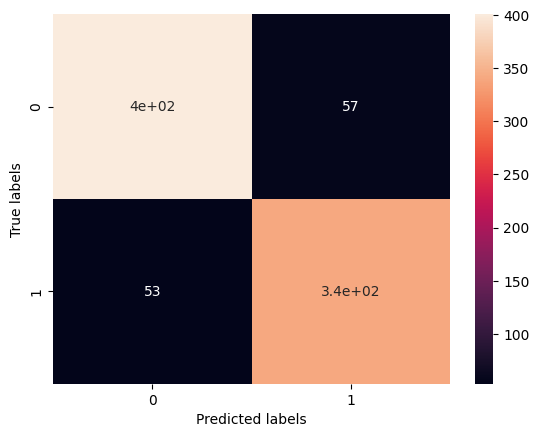

In [66]:

X = np.array(list(sep_df.drop("label", axis=1).values))
y = np.array(list(sep_df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = X_train_encoded, X_test_encoded, y_train, y_test

X_train, X_test = cap_outliers_descr(X_train, X_test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(2000, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1000, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(400, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)

add_df = pd.DataFrame({'Model': 'AE model ', 'features': 'all features (encoded)', 'cv_accuracy': np.mean(acc_per_fold),
                              'test_accuracy': test_acc,
                              'model_instance': model}, index=[4])

models_df = pd.concat([models_df, add_df], ignore_index=True)

                       


### AE model with morgan fingerprints


In [57]:
X = np.array(list(df["morgan_fingerprint"]))
y = np.array(list(df["label"]))

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Define the size of the encoded representations
encoding_dim = 200

# layers
input_data = Input(shape=(X_train.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_data)
decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)


# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# we can extract features (encoding) with the encoder model
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

Epoch 1/10
107/107 [==============================] - 2s 12ms/step - loss: 0.0473 - val_loss: 0.0192
Epoch 2/10
107/107 [==============================] - 1s 13ms/step - loss: 0.0187 - val_loss: 0.0187
Epoch 3/10
107/107 [==============================] - 2s 18ms/step - loss: 0.0181 - val_loss: 0.0180
Epoch 4/10
107/107 [==============================] - 2s 16ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 5/10
107/107 [==============================] - 1s 10ms/step - loss: 0.0166 - val_loss: 0.0166
Epoch 6/10
107/107 [==============================] - 2s 16ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 7/10
107/107 [==============================] - 1s 14ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 8/10
107/107 [==============================] - 2s 17ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 9/10
107/107 [==============================] - 2s 14ms/step - loss: 0.0141 - val_loss: 0.0145
Epoch 10/10
27/27 [==============================] - 0s 6ms/step


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.3525254726409912; accuracy of 84.85293984413147%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.3580342233181; accuracy of 85.73529124259949%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.32947254180908203; accuracy of 85.4411780834198%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.33294856548309326; accuracy of 84.41176414489746%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.37272149324417114; accuracy of 85.14705896377563%

Mean accuracy in folds:  85.11764645576477

Evaluation on test set: 
27/27 [==============================] - 0s 1ms/step
        

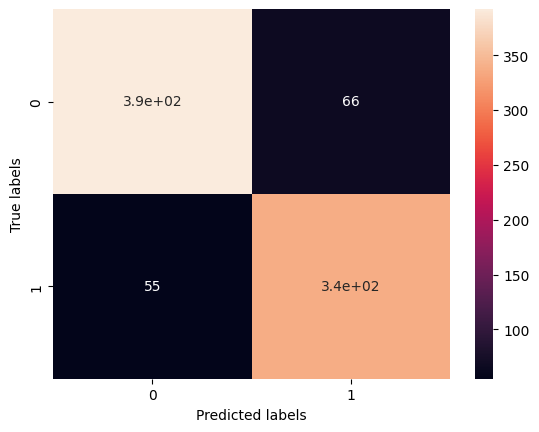

In [60]:

X = np.array(list(sep_df.drop("label", axis=1).values))
y = np.array(list(sep_df["label"]))

# split train and test with train test split
X_train, X_test, y_train, y_test = X_train_encoded, X_test_encoded, y_train, y_test
# scale data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


def create_model():
  # define the model
  model = Sequential()

  model.add(Dense(250, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(175, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(80, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation= "sigmoid"))

  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

# perform cross validation
acc_per_fold, loss_per_fold = cross_validation(X_train, y_train, create_model, n_splits=5, verbose = 0)

# train model on whole train set and test in on the independent test set
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
print("\nEvaluation on test set: ")
evaluate_model(model, X_test, y_test, threshold=0.5)


# add a row to the models_df dataframe
preds =  model.predict(X_test) > 0.5
test_acc = accuracy_score(y_test, preds)

add_df = pd.DataFrame({'Model': 'AE model', 'features': 'morgan fing (encoded)', 'cv_accuracy': np.mean(acc_per_fold),
                              'test_accuracy': test_acc,
                              'model_instance': model}, index=[5])

models_df = pd.concat([models_df, add_df], ignore_index=True)

### GCNN model

In [ ]:
import deepchem as dc


# Define the cross-validation function, not used in the end
def cross_validation_cnn(X, y, model, n_splits=5, epochs=5):

  acc_per_fold = []
  loss_per_fold = []

  # Define the evaluator for model evaluation metrics
  evaluator = Evaluator(model, dataset, transformers = [])

  cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

  # Perform cross-validation
  fold = 1
  for train_index, test_index in cv.split(X, y):
      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold} ...')
      # Split the dataset into training and test sets for the fold
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # Create DeepChem datasets for training and testing
      train_dataset = dc.data.NumpyDataset(X=X_train, y=y_train)
      test_dataset = dc.data.NumpyDataset(X=X_test, y=y_test)

      # Train the model on the training set
      model.fit(train_dataset, nb_epoch=epochs)

      # Evaluate the model on the test set
      metrics = evaluator.compute_model_performance(test_dataset)

      # Print the evaluation metrics for the fold
      print(f"\nFold {fold} metrics:")
      for metric_name, metric_value in metrics.items():
          print(f"{metric_name}: {metric_value}")

      fold += 1


  print("\nMean accuracy in folds: ", np.mean(acc_per_fold))
  return acc_per_fold, loss_per_fold

OSError: [WinError 182] The operating system cannot run %1. Error loading "c:\Installed_programs\Conda\envs\bio_grasso\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [ ]:
features = df.drop('label', axis=1)
target = df['label']

# Define the graph and featurize the molecules
featurizer = dc.feat.ConvMolFeaturizer()

graph_features = featurizer.featurize(df['smiles'])


# Create a DeepChem dataset
dataset = dc.data.NumpyDataset(graph_features, target.values)


splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset)

NameError: name 'dc' is not defined

In [ ]:
def create_model():
    model = dc.models.GraphConvModel(n_tasks=1, mode='classification', model_dir='model_dir', batch_size=128, random_seed=0)
    return model

In [ ]:
model = create_model()
model.fit(train_dataset, nb_epoch=100)

In [ ]:
# Evaluate the model on the test set
metrics = dc.metrics.Metric(dc.metrics.accuracy_score)
score = model.evaluate(test_dataset, [metrics])
score

In [ ]:
y_true = test_dataset.y
y_pred = model.predict(test_dataset)[:, :, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# add a row to the models_df dataframe
pred = y_pred > 0.5
test_acc = accuracy_score(test_dataset.y, pred)

add_df = pd.DataFrame({'Model': 'GCNN', 'features': 'graph features', 'cv_accuracy': 0.0,
                              'test_accuracy': test_acc,    
                              'model_instance': model}, index=[2])

models_df = pd.concat([models_df, add_df], ignore_index=True)

### Results table

In [61]:
# moltiply test_accuracy column by 100 and round to 2 places cv_acuracy and  test_accuracy column 
models_df["cv_accuracy"] = round(models_df["cv_accuracy"], 2)
models_df["test_accuracy"] = round(models_df["test_accuracy"]*100, 2)

From the results we can see that the best performing model is the MLP with all the features and PCS applied. After that follow the AutoEncoder model and the Random Forest, with a slightly lower CV accuracy.

In [62]:
models_df

,Model,features,cv_accuracy,test_accuracy,model_instance
0,MLP,all features and pca,88.76,88.95,<keras.engine.sequential.Sequential object at ...
1,MLP,features,70.62,75.56,<keras.engine.sequential.Sequential object at ...
2,MLP,morgan fingerprint,86.50,87.43,<keras.engine.sequential.Sequential object at ...
3,Support vector machine,moorgan_fingerprint,86.79,89.19,SVC()
4,MLP,mold2,85.65,87.19,<keras.engine.sequential.Sequential object at ...
5,Random Forest,mold2,85.47,86.72,/
6,MLP,maccs keys,81.74,85.90,<keras.engine.sequential.Sequential object at ...
7,MLP,rdkit,85.26,87.07,<keras.engine.sequential.Sequential object at ...
8,Random Forest,rdkit,85.97,87.43,/
9,AE model,all features (encoded),88.85,88.01,<keras.engine.sequential.Sequential object at ...


### Explanability

We perform some model explanability in order to understand how the model choses which molecules are more likely to be a drug.

In [ ]:
import exmol

Could not import azure.core python package.


In [ ]:

# pick a sample with label 1
sample = sep_df[sep_df["label"] == 1].sample(1)
sample

,label,morgan_fingerprint_0,morgan_fingerprint_1,morgan_fingerprint_2,morgan_fingerprint_3,morgan_fingerprint_4,morgan_fingerprint_5,morgan_fingerprint_6,morgan_fingerprint_7,morgan_fingerprint_8,...,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea,rdkit_qed,feature_molecular_weight,feature_logP,feature_num_rotatable_bonds,feature_num_hydrogen_bond_donors,feature_num_hydrogen_bond_acceptors
2617,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.32829,249.096,-1.2732,5.0,3.5,4.0


In [ ]:
model = models_df[models_df['Model'] == 'MLP (2048)']['model_instance'].values[0]


In [ ]:
smile = 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O' # ibuprofen


mol = Chem.MolFromSmiles(smile)
X_drugs = mol
X_pred = np.array(smiles_to_morgan_fingerprint(X_drugs)).reshape((1, 2048))
y_pred = model.predict(X_pred)
y_pred

1/1 [==============================] - 0s 19ms/step


array([[0.9996991]], dtype=float32)

The model is very confident that ibuprofene is a drug

In [ ]:
drug_encoding = 'Morgan'

def predictor(smiles):
    mol = Chem.MolFromSmiles(smiles)
    X_drugs = mol
    X_pred = np.array(smiles_to_morgan_fingerprint(X_drugs)).reshape((1, 2048))
    y_pred = model.predict(X_pred)
    answ = 1 if y_pred[0] > 0.5 else 0
    return answ

space = exmol.sample_space(smile, predictor, batched=False)

1/1 [==============================] - 0s 23ms/step


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:03<00:00, 996.28it/s]

1/1 [==============================] - 0s 32ms/step


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:18<00:00, 996.28it/s]

1/1 [==============================] - 0s 48ms/step


🤘Done🤘: 100%|██████████| 2185.0/2185 [00:05<00:00, 393.59it/s]                     


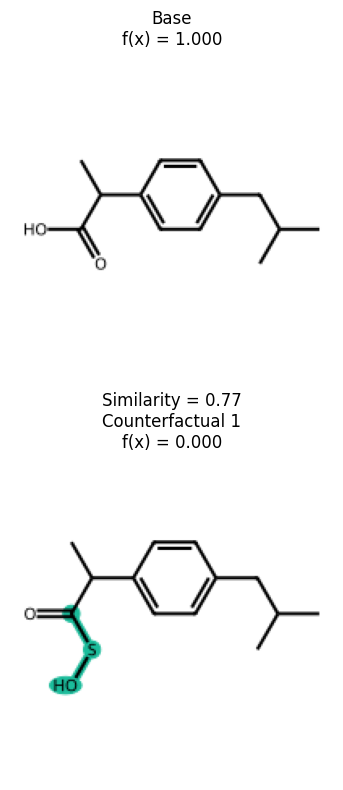

In [ ]:
cfs = exmol.cf_explain(space, 1)
exmol.plot_cf(cfs)


We can se that adding s and HO atoms to the ibuprofene molecule is the smallest change that change the prediction 

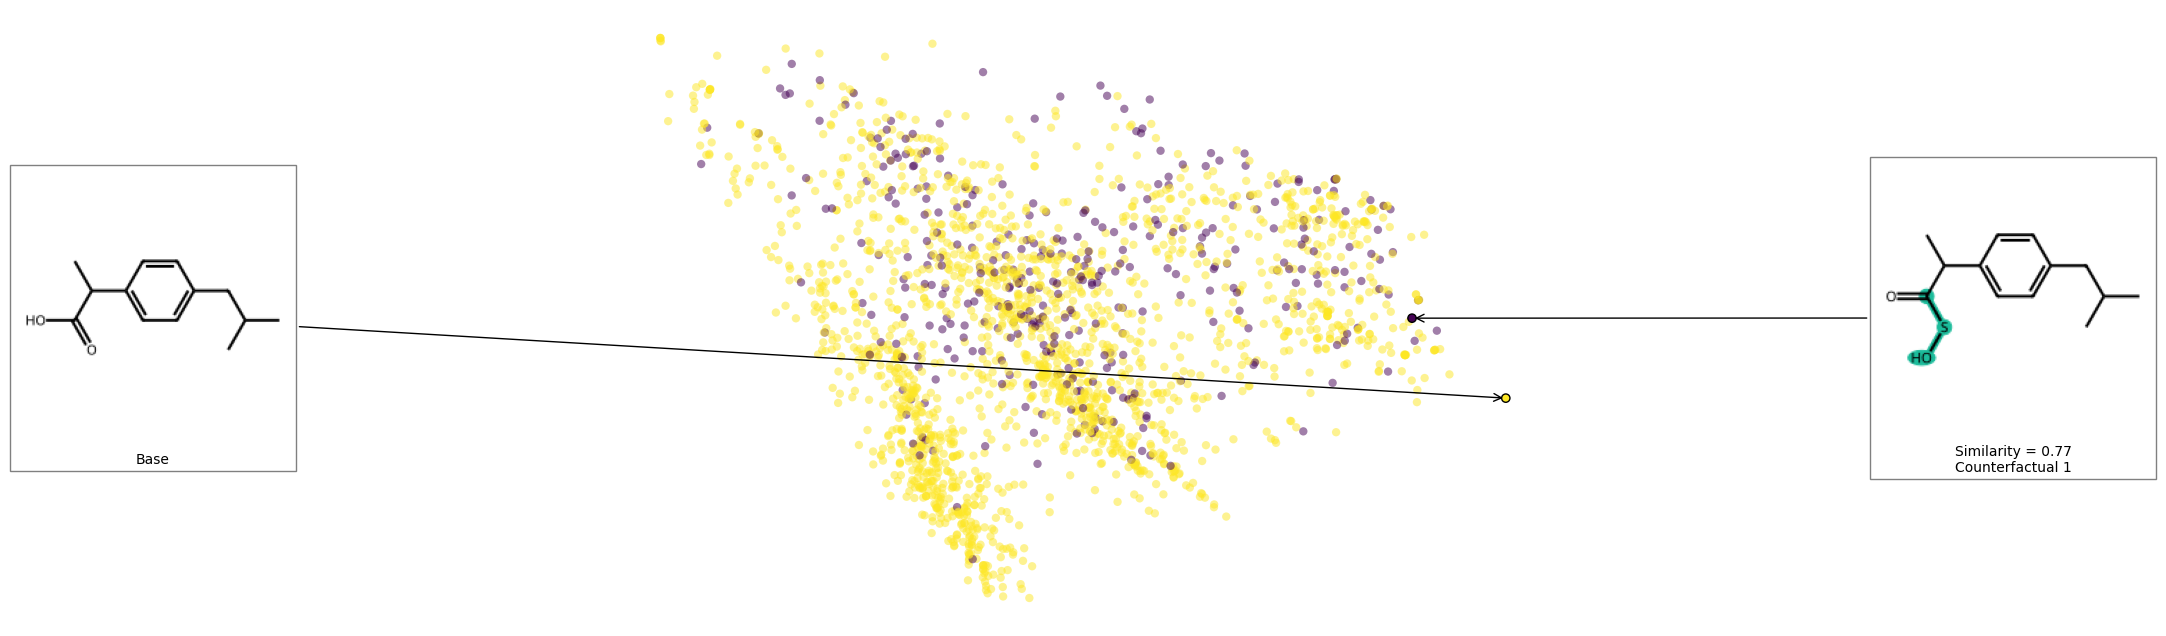

In [ ]:
#Plot chemical space around example and annotate given examples (PCA 2 components)
#MACCSfps, ECFP fingerprints, and RdKit chemical descriptors 
exmol.plot_space(space, cfs)


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)


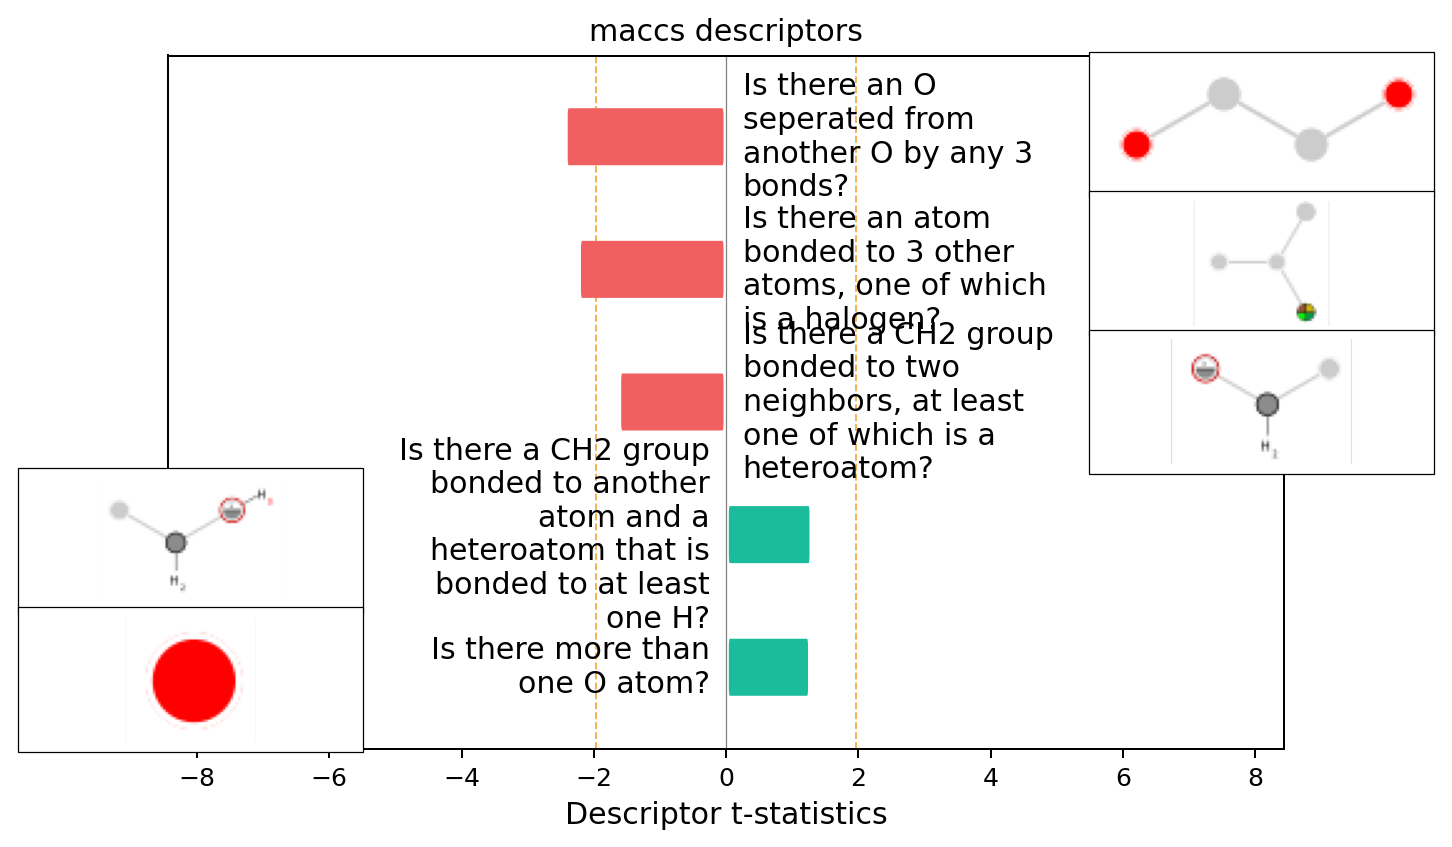

In [ ]:
exmol.lime_explain(space)
exmol.plot_descriptors(space)

In [ ]:
import skunk

exmol.lime_explain(space, descriptor_type='ECFP')
svg = exmol.plot_descriptors(space, return_svg=True)
skunk.display(svg)
svg = exmol.plot_utils.similarity_map_using_tstats(space[0], return_svg=True)
skunk.display(svg)